In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))

path_pipeline = path_git.joinpath("sisepuede_data_pipeline")

import warnings
warnings.filterwarnings("ignore")


import os, os.path
import numpy as np
import pandas as pd
import rioxarray as rx

#from sisepuede.core.model_attributes import *
import sisepuede.core.model_attributes as ma
import sisepuede.models.afolu as mafl
import sisepuede.models.ippu as mi
import sisepuede.models.circular_economy as mc
import sisepuede.models.energy_production as ml
import sisepuede.models.energy_consumption as me
import sisepuede.models.socioeconomic as se
import sisepuede.core.model_variable as mv

#import sisepuede.legacy.setup_analysis as sa
#import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_models as sm
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import importlib
import pathlib
import time
import warnings
import matplotlib.pyplot as plt
from typing import *

import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.plotting.plots as spp
import sisepuede.transformers.lib._baselib_afolu as tba
import sisepuede.transformers.lib._baselib_circular_economy as tbc
import sisepuede.transformers.lib._baselib_energy as tbe
import sisepuede.transformers.lib._baselib_general as tbg
import sisepuede.transformers.lib._baselib_ippu as tbi
import sisepuede.utilities._plotting as spu

import afolu.geo.lib._get_gridded_dataset as gridded
import lib.data_construction_utilities as util
import lib.data_objects as do
import lib._data_source_utils._iea as ieautils
import lib._geo as geolib
import lib._geo_classes as gcl
import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil


# initialize two large datasets
gridded_data = None
regions_grid_index = None

#
#   WRITE EVERYTHING TO OUTPUTS
#


In [2]:
##  SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")


##  SETUP FILES

path_data_calib = path_data.joinpath("input_all_sectors_mongolia.csv")
path_data_base = "https://raw.githubusercontent.com/sisepuede-framework/ssp_uganda/refs/heads/main/ssp_modeling/input_data/ssp_inputs_uganda_BaU_Scenario.csv"#path_data.joinpath("MNG_real_data_20250604.csv")


##  SETUP SOME PIPELINE STUFF

importlib.reload(dc)
construct = dc.SISEPUEDEDataConstructs(
    path_output_database = "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite",
)

path_repo = pathlib.Path("/Users/usuario/SISEPUEDE_DATA_REPOSITORY")
repo = pu.Repository(
    {
        "local": {
            "path": str(path_repo)
        }
    }
)


# assign some shortcuts
file_struct = construct.sisepuede_file_struct
matt = file_struct.model_attributes
regions = construct.regions
time_periods = construct.time_periods


##  SOME GLOBALS

_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )








# Bulid with data we have

- Pull data fromo original repo (df_uganda_base)
- Update with latest data (from new repo)
- Fill in values for new vars using `temp_update_fields_from_wv_to_main`
- Check if anything is missing

In [89]:
fields_drop_uganda_base

['exports_enfu_pj_fuel_electricity',
 'exports_enfu_pj_fuel_gasoline',
 'frac_enfu_fuel_demand_imported_pj_fuel_oil',
 'exports_enfu_pj_fuel_coal',
 'frac_enfu_fuel_demand_imported_pj_fuel_kerosene',
 'exports_enfu_pj_fuel_hydrocarbon_gas_liquids',
 'frac_enfu_fuel_demand_imported_pj_fuel_natural_gas',
 'exports_enfu_pj_fuel_oil',
 'exports_enfu_pj_fuel_natural_gas',
 'frac_enfu_fuel_demand_imported_pj_fuel_gasoline',
 'frac_enfu_fuel_demand_imported_pj_fuel_diesel',
 'frac_enfu_fuel_demand_imported_pj_fuel_hydrocarbon_gas_liquids',
 'frac_enfu_fuel_demand_imported_pj_fuel_crude',
 'exports_enfu_pj_fuel_kerosene',
 'exports_enfu_pj_fuel_diesel',
 'exports_enfu_pj_fuel_crude',
 'frac_enfu_fuel_demand_imported_pj_fuel_coal',
 'frac_enfu_fuel_demand_imported_pj_fuel_electricity',
 'gdp_mmm_usd_pct_change']

In [133]:
import temp_update_fields_from_wv_to_main as temp 

examples = sxl.SISEPUEDEExamples()

def build_var_replacements_dict(
    model_attributes: 'ModelAttributes'
) -> Dict[str, float]:
    """Build a dictionary mapping fields to replacement values
    """
    modvar_enfu_exports = model_attributes.get_variable("Fuel Exports")
    modvar_enfu_imports = model_attributes.get_variable("Fraction of Fuel Demand Imported")
    
    # set some defaults to 0
    dict_rpl = dict(
        (x, 0)
        for x in fields_drop_uganda_base
        if x in modvar_enfu_exports.fields
    )
    
    dict_rpl.update(
        dict(
            (x, 1)
            for x in fields_drop_uganda_base
            if x in modvar_enfu_imports.fields
        )
    )
    
    dict_rpl.update(
        {
            modvar_enfu_imports.build_fields(category_restrictions = "fuel_electricity"): 0.0,
        }
    )

    return dict_rpl




# in example, convert to years
df_example_input = examples("input_data_frame").copy()
df_example_input = (
    time_periods
    .tps_to_years(df_example_input )
    .drop(columns = [time_periods.field_time_period], )
)


# get from original repo
df_uganda_base = (
    pd.read_csv(path_data_base)
    .rename(
        columns = {
            "iso_code3": regions.field_iso,
            "Year": time_periods.field_year,
        }
    )
)

# drop NA fields
fields_drop_uganda_base = [
    x for x in df_uganda_base.columns 
    if df_uganda_base[x].dropna().shape[0] != df_uganda_base.shape[0]
]
df_uganda_base = df_uganda_base.drop(columns = fields_drop_uganda_base)
dict_specified_vals = build_var_replacements_dict(matt, )
for k, v in dict_specified_vals.items():
    if k not in df_uganda_base.columns:
        df_uganda_base[k] = v
        

# conver to iso
df_uganda_base = (
    regions
    .add_region_or_iso_field(df_uganda_base, )
    .drop(columns = [regions.key], )
)

# convert to years
df_uganda_base = (
    time_periods
    .tps_to_years(df_uganda_base )
    .drop(columns = [time_periods.field_time_period], )
)


##  TURN OFF SOME CONSTRAINTS IN AFOLU

model_afolu = mafl.AFOLU(matt, )
modvar_constraint_upper = matt.get_variable(model_afolu.modvar_lndu_constraint_area_max)
modvar_constraint_lower = matt.get_variable(model_afolu.modvar_lndu_constraint_area_min)
df_uganda_base[modvar_constraint_upper.fields + modvar_constraint_lower.fields] = -999


# get from pipeline -- will overwrite afolu constraints where viable
df_from_pipeline = construct.build_inputs_from_database(
    regions_keep = [_REGION_NAME],
)

# add from baseline and fill
fields_merge = [
    x for x in df_uganda_base.columns if x not in df_from_pipeline 
    and x not in [construct.time_periods.field_time_period]
]

"""
# add in pipeline-based data
df_uganda = sf.match_df_to_target_df(
    df_uganda_base[
        df_uganda_base[regions.field_iso].isin([_REGION_ISO])
    ],
    
    df_from_pipeline
    .drop(columns = [regions.field_iso]),
    
    [
        construct.time_periods.field_year,
    ],
    overwrite_only = False,
)
"""
df_uganda = (
    pd.merge(
        df_from_pipeline
        .drop(columns = [regions.field_iso]), 
        df_uganda_base[
            df_uganda_base[regions.field_iso].isin([_REGION_ISO])
        ]
        .get([time_periods.field_year] + fields_merge),
        how = "left"
    )
    .ffill()
)




##  PULL FROM EXAMPLE DF

# fields not in uganda
fields_missing = [
    x for x in df_example_input.columns 
    if (x not in df_uganda.columns) 
    and (x in matt.all_variable_fields_input)
]

# specify fields to pull from the example
fields_from_ex = [
    x for x in fields_missing 
    if not (
        x.startswith("factor_lndu")
        or x.startswith("frac_lndu_")
    )
]

fields_from_ex = [
    x for x in fields_from_ex
    if (x not in df_uganda.columns)
]

# merge in from ex
df_uganda = (
    pd.merge(
        df_uganda,
        df_example_input[fields_from_ex + [time_periods.field_year]],
        how = "left",
    )
    .ffill()
)


##  TEMPORARY SCRIPT FOR MOVING FROM working_version TO latest full version
#raise RuntimeError("break")
df_uganda = temp.update_fields(
    df_uganda,
    matt,
)


##  TURN OFF SOME ENERGY PIECES

vars_off = [
    #"NemoMod MinShareProduction",
    "NemoMod TotalAnnualMaxCapacity",
    "NemoMod TotalAnnualMaxCapacityInvestment"
]
for modvar in vars_off:
    modvar = matt.get_variable(modvar)
    df_uganda[modvar.fields] = -999


# add a cap to new nuclear
#modvar_mci = matt.get_variable("NemoMod TotalAnnualMaxCapacityInvestment")
#fields = modvar_mci.build_fields(category_restrictions = ["pp_nuclear", "pp_biomass"])
#df_uganda[fields] = 0.0

# cap hydro using max increase to satisfy msp
#modvar_nomsp = matt.get_variable("Maximum Production Increase Fraction to Satisfy MinShareProduction Electricity")
#field_nomsp = modvar_nomsp.build_fields(category_restrictions = "pp_hydropower")
#df_uganda[field_nomsp][10:] = list(0.01 - np.arange(10)*0.001) + list(np.zeros(16))
#field_hp = modvar_mci.build_fields(category_restrictions = ["pp_hydropower"])
#df_uganda[field_hp][0:10] = 0
# TEMP-kluge hydropower by making it extremely expensive
#modvar_mc = matt.get_variable("NemoMod TotalAnnualMaxCapacity")
#df_uganda[modvar_mc.build_fields(category_restrictions = "pp_hydropower")] = 0.1


## TEMP
df_uganda["lndu_reallocation_factor"] = 0.

# add in key
df_uganda[regions.key] = _REGION_NAME


adding field factor_lndu_soil_carbon_pastures
adding field factor_lndu_soil_management_supremum_pastures
adding field factor_lndu_soil_management_unimproved_pastures
adding field frac_lndu_improved_pastures
adding field frac_lndu_increasing_net_exports_met_pastures
adding field frac_lndu_increasing_net_imports_met_pastures
adding field frac_lndu_pastures_cl1_temperate
adding field frac_lndu_pastures_cl1_tropical
adding field frac_lndu_pastures_cl2_dry
adding field frac_lndu_pastures_cl2_wet
adding field frac_lndu_receiving_fertilizer_pastures
adding field frac_lndu_soil_mineral_pastures
adding field frac_lndu_soil_mineral_shrublands
adding field frac_lndu_soil_mineral_wetlands
adding field factor_lndu_soil_carbon_flooded
adding field factor_lndu_soil_carbon_shrublands
adding field frac_lndu_soil_mineral_flooded
adding field frac_lndu_utilization_rate_pastures


np.int64(2015)

# Build MSP data for Uganda

In [134]:
# UPDATE THE ATTRIBUTE TABLE FIRST
ys = df_uganda[time_periods.field_year]
y0, y1 = ys.min(), ys.max()

attr_time_period = pd.DataFrame(
    {
        time_periods.field_year: range(y0, y1 + 1),
        time_periods.field_time_period: range(0, y1 + 1 - y0)
    }
)
matt.update_dimensional_attribute_table(
    attr_time_period,
    key = time_periods.field_time_period,
)

# add to df_uganda
df_uganda = time_periods.years_to_tps(df_uganda, )


# BUILD MODELS

importlib.reload(sm)
models = sm.SISEPUEDEModels(
    matt,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)




data_elec = pd.read_csv(path_data.joinpath("International Energy Agency - electricity generation sources in Uganda.csv"))
data_elec = do.DatasetIEA(data_elec.drop(columns = "Units"))
_FIELD_SOURCE = "electricity generation sources in Uganda"
_FIELD_VALUE = "value"

df_cw = pd.read_csv("/Users/usuario/git/sisepuede/sisepuede/ref/data_crosswalks/iea_fuel_categories.csv")
cat_fuel_primary = matt.get_subsector_attribute("Energy Fuels", "primary_category")

# get a dictionary converting the IEA fuels to sisepuede fuels
dict_iea_to_fuels = ieautils.build_iea_fuel_crosswalk(
    df_cw,
    matt,
)

## ADD A MANUAL UPDATE - biomass is the primary biofuel in Uganda, but it's classified as biofuels
dict_iea_to_fuels.update({"Biofuels": "``fuel_biomass``"})




df = (
    sf.pivot_df_clean(
        data_elec.df,
        [_FIELD_SOURCE],
        [data_elec.field_value]
    )
    .fillna(0.0)
)

# convert to fractions
fields_fuel = [x for x in df.columns if x not in [data_elec.field_year]]
arr = df[fields_fuel].to_numpy()
arr = sf.do_array_mult(arr, 1/arr.sum(axis = 1),)   
df[fields_fuel] = arr 


##  GET MAPPING OF FUEL TO BASE POWER PLANT TECHS

pycat_enfu = matt.get_subsector_attribute(
    matt.subsec_name_enfu, 
    "pycategory_primary_element",
)

dict_techs_to_fuel = matt.get_ordered_category_attribute(
    matt.subsec_name_entc,
    f"electricity_generation_{pycat_enfu}",
    clean_attribute_schema_q = True,
    return_type = dict,
    skip_none_q = True,
)

dict_techs_to_fuel_noccs = dict(
    (k, v) for k, v in dict_techs_to_fuel.items() if "ccs" not in k
)

dict_fuel_to_tech_no_ccs = sf.reverse_dict(dict_techs_to_fuel_noccs)


##  MELT AND CONVERT IEA FUELS TO SISEPUEDE TECHS, THEN BUILD FIELDS

df = (
    df.melt(
        id_vars = [data_elec.field_year],
        value_vars = fields_fuel,
        var_name = cat_fuel_primary,
        value_name = _FIELD_VALUE,
    )
    .rename(
        columns = {data_elec.field_year: time_periods.field_year, }
    )
)

df[cat_fuel_primary] = (
    df[cat_fuel_primary]
    .replace(dict_iea_to_fuels)
    .apply(ma.clean_schema)
    .replace(dict_fuel_to_tech_no_ccs)
)

# get MSP variable and shift to wide
modvar_msp = matt.get_variable("NemoMod MinShareProduction")
df = lutil.long_cats_to_wide_fields_complete(
    df,
    None,
    cat_fuel_primary,
    _FIELD_VALUE,
    time_periods.field_year,
    matt,
    modvar = modvar_msp,
)

# finally, fill missing fields with zeros
fields_complete = modvar_msp.build_fields(
    category_restrictions = models.model_enerprod.get_entc_cat_by_type("pp")
)

df[[x for x in fields_complete if x not in df.columns]] = 0.0

# merge into available data\
df = time_periods.years_to_tps(df)
df = (
    pd.merge(
        df_uganda[[time_periods.field_time_period]],
        df.drop(columns = time_periods.field_year),
        how = "left", 
    )
    .ffill()
)



df_uganda = sf.match_df_to_target_df(
    df_uganda,
    df,
    [construct.time_periods.field_time_period],
    overwrite_only = False,
)


nemomod_entc_annual_production_by_technology_pp_biogas                0.000000e+00
nemomod_entc_annual_production_by_technology_pp_biomass               0.000000e+00
nemomod_entc_annual_production_by_technology_pp_coal                  0.000000e+00
nemomod_entc_annual_production_by_technology_pp_coal_ccs              0.000000e+00
nemomod_entc_annual_production_by_technology_pp_gas                   0.000000e+00
nemomod_entc_annual_production_by_technology_pp_gas_ccs               0.000000e+00
nemomod_entc_annual_production_by_technology_pp_geothermal            0.000000e+00
nemomod_entc_annual_production_by_technology_pp_hydropower            0.000000e+00
nemomod_entc_annual_production_by_technology_pp_nuclear               0.000000e+00
nemomod_entc_annual_production_by_technology_pp_ocean                 0.000000e+00
nemomod_entc_annual_production_by_technology_pp_oil                   0.000000e+00
nemomod_entc_annual_production_by_technology_pp_solar                 0.000000e+00
nemo

In [142]:
modvar = matt.get_variable("NemoMod Production by Technology")
arr = modvar.get_from_dataframe(df_out, )

In [139]:
df_out = models.project(df_uganda.iloc[0:56], include_electricity_in_energy = True, )

2025-15-Aug 11:08:18.503 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/uganda_testing/tmphx_a37cw.sqlite.
2025-15-Aug 11:08:18.652 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/uganda_testing/tmphx_a37cw.sqlite.
2025-15-Aug 11:08:27.361 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-15-Aug 11:08:52.278 Finished modeling scenario.


<Axes: >

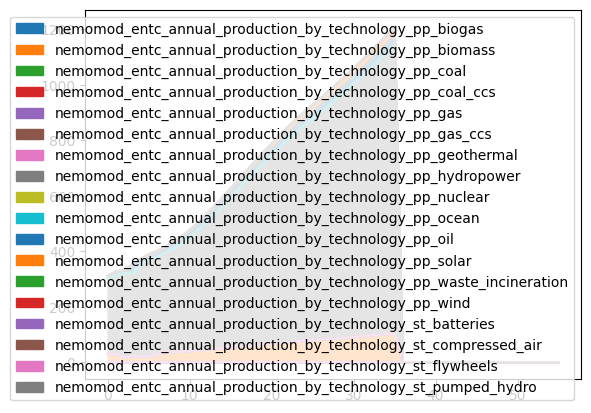

In [146]:
modvar = matt.get_variable("NemoMod Production by Technology")
arr = modvar.get_from_dataframe(df_out, )
#arr = arr[[x for x in arr.columns if arr[x].min() > 0]]
arr.plot.area()

In [7]:
df_out_noep = models.project(df_uganda, include_electricity_in_energy = False, )
df_test = pd.merge(
    df_uganda,
    df_out_noep,
)

modvar = matt.get_variable("NemoMod Production by Technology")
modvar.get_from_dataframe(df_out, )



,nemomod_entc_annual_production_by_technology_pp_biogas,nemomod_entc_annual_production_by_technology_pp_biomass,nemomod_entc_annual_production_by_technology_pp_coal,nemomod_entc_annual_production_by_technology_pp_coal_ccs,nemomod_entc_annual_production_by_technology_pp_gas,nemomod_entc_annual_production_by_technology_pp_gas_ccs,nemomod_entc_annual_production_by_technology_pp_geothermal,nemomod_entc_annual_production_by_technology_pp_hydropower,nemomod_entc_annual_production_by_technology_pp_nuclear,nemomod_entc_annual_production_by_technology_pp_ocean,nemomod_entc_annual_production_by_technology_pp_oil,nemomod_entc_annual_production_by_technology_pp_solar,nemomod_entc_annual_production_by_technology_pp_waste_incineration,nemomod_entc_annual_production_by_technology_pp_wind,nemomod_entc_annual_production_by_technology_st_batteries,nemomod_entc_annual_production_by_technology_st_compressed_air,nemomod_entc_annual_production_by_technology_st_flywheels,nemomod_entc_annual_production_by_technology_st_pumped_hydro
0,0.000000,0.000000,30.318712,0.0,0.0,0.0,0.0,0.353379,0.0,-6.940424e-14,1.377579,0.047916,0.000000,0.922379,0.0,0.000000e+00,0.000000e+00,0.0
1,0.000000,0.000000,32.507865,0.0,0.0,0.0,0.0,0.528634,0.0,0.000000e+00,1.200310,0.049754,0.000000,0.957760,0.0,0.000000e+00,0.000000e+00,0.0
2,0.000275,0.000000,33.125689,0.0,0.0,0.0,0.0,0.499715,0.0,0.000000e+00,1.673744,0.162558,0.015349,0.832994,0.0,0.000000e+00,0.000000e+00,0.0
3,0.000564,0.000000,32.852211,0.0,0.0,0.0,0.0,0.446152,0.0,0.000000e+00,1.670643,0.352569,0.032121,1.704623,0.0,0.000000e+00,0.000000e+00,0.0
4,0.000864,0.019489,32.348051,0.0,0.0,0.0,0.0,0.494175,0.0,0.000000e+00,2.063239,0.641651,0.049930,2.632981,0.0,0.000000e+00,0.000000e+00,0.0
5,0.001163,0.019489,32.190933,0.0,0.0,0.0,0.0,0.479427,0.0,0.000000e+00,2.050562,0.707474,0.065628,2.749486,0.0,0.000000e+00,0.000000e+00,0.0
6,0.001414,0.019489,32.319965,0.0,0.0,0.0,0.0,0.402131,0.0,0.000000e+00,1.752877,0.896482,0.081318,2.990203,0.0,5.378361e-13,0.000000e+00,0.0
7,0.001434,0.007607,33.534204,0.0,0.0,0.0,0.0,0.317645,0.0,0.000000e+00,1.709231,1.002279,0.083733,2.566367,0.0,0.000000e+00,0.000000e+00,0.0
8,0.001457,0.019489,34.447790,0.0,0.0,0.0,0.0,0.381039,0.0,0.000000e+00,1.755796,0.963357,0.087072,2.636284,0.0,0.000000e+00,0.000000e+00,0.0
9,0.001480,0.019489,35.362670,0.0,0.0,0.0,0.0,0.391836,0.0,0.000000e+00,1.802427,0.988942,0.090386,2.706300,0.0,0.000000e+00,4.453844e-14,0.0


<Axes: >

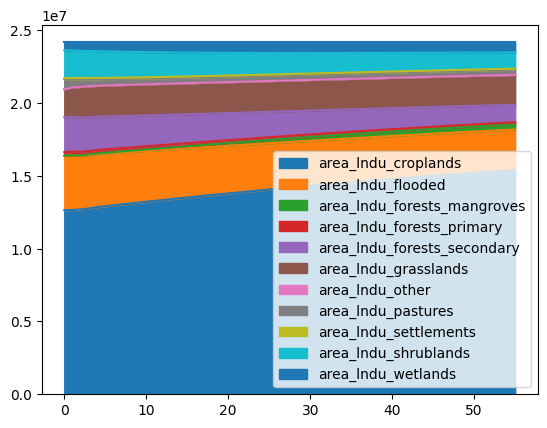

In [147]:
modvar_area = matt.get_variable("Land Use Area")
modvar_area.get_from_dataframe(df_out).plot.area()

# transformations|

In [31]:
import sisepuede.transformers as trf

transformers = trf.Transformers(
    {},
    df_input = df_uganda,
)


transformations = trf.Transformations(
    path_transformations,
    transformers = transformers,
)

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)


# build templates
df_vargroups = examples("variable_trajectory_group_specification")
strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = True,
    strategies = [0, 6002],
)

0

In [88]:
modvar_mci.get_from_dataframe(df_test).iloc[-1]

nemomod_entc_total_annual_max_capacity_investment_pp_biogas_gw               -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_biomass_gw              -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_coal_gw                 -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_coal_ccs_gw             -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_gas_gw                  -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_gas_ccs_gw              -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_geothermal_gw           -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_hydropower_gw              0.0
nemomod_entc_total_annual_max_capacity_investment_pp_nuclear_gw                 0.0
nemomod_entc_total_annual_max_capacity_investment_pp_ocean_gw                -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_oil_gw                  -999.0
nemomod_entc_total_annual_max_capacity_investment_pp_solar_gw               

In [156]:
strat = strategies.get_strategy(6002)
df_test = strat()

In [157]:
df_out = models(df_test)


2025-22-Jun 11:04:20.595 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/mongolia/tmp7g3w791v.sqlite.
2025-22-Jun 11:04:20.602 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/mongolia/tmp7g3w791v.sqlite.
2025-22-Jun 11:04:21.369 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-22-Jun 11:05:00.806 Finished modeling scenario.


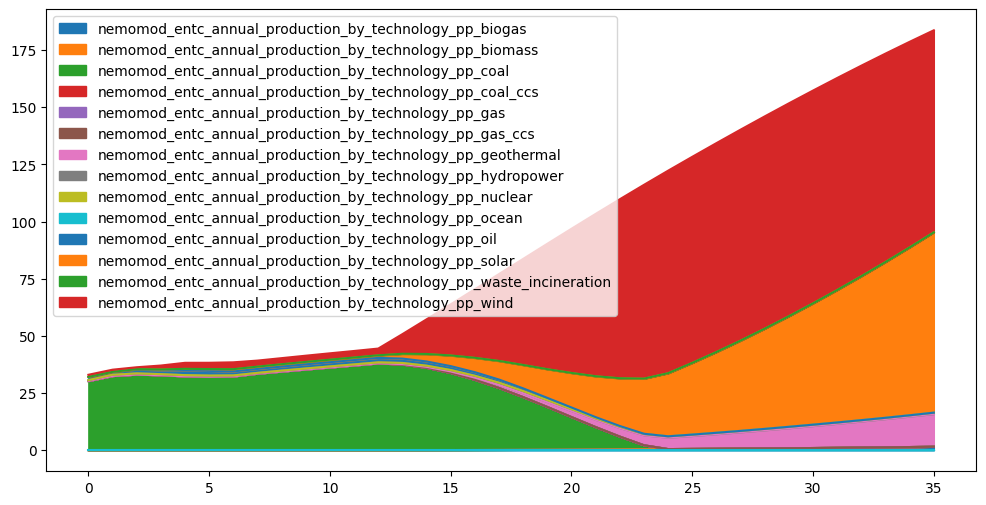

In [158]:
modvar_pt.get_from_dataframe(df_out)["nemomod_entc_annual_production_by_technology_pp_hydropower"]
modvar_gc = matt.get_variable("NemoMod Generation Capacity")
modvar_gc.get_from_dataframe(df_out)#["nemomod_entc_annual_production_by_technology_pp_hydropower"]

fig, ax = plt.subplots(figsize = (12, 6))
df_plot = modvar_pt.get_from_dataframe(df_out)
df_plot = df_plot[[x for x in df_plot.columns if "_st_" not in x]].plot.area(ax = ax)

In [159]:
import sisepuede as si
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False,
    regions = ["mongolia"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)





2025-06-22 11:05:26,555 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-22 11:05:26,555 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-22 11:05:26,555 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-22 11:05:26,555 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-22 11:05:26,555 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-22 11:05:26,557 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-06-22 11:05:26,557 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-06-22 11:05:26,557 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-06-22 11:05:26,557 - WARNING - Missing key dict_dimensional_keys: key time_series not found. 

In [160]:

dict_run = {
    ssp.key_future: [0],
    ssp.key_design: [0],
    ssp.key_strategy: [
        0, 
        strategies.get_strategy_id("PFLO:ALL")
    ],
}

# we'll save inputs since we're doing a small set of runs
ssp(
    dict_run,
    force_overwrite_existing_primary_keys = True,
    save_inputs = True,
)

2025-06-22 11:05:40,006 - INFO - 
***	STARTING REGION mongolia	***

2025-06-22 11:05:40,006 - INFO - 
***	STARTING REGION mongolia	***

2025-06-22 11:05:40,006 - INFO - 
***	STARTING REGION mongolia	***

2025-06-22 11:05:40,006 - INFO - 
***	STARTING REGION mongolia	***

2025-06-22 11:05:40,006 - INFO - 
***	STARTING REGION mongolia	***

2025-06-22 11:05:41,468 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-22 11:05:41,468 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-22 11:05:41,468 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-22 11:05:41,468 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-22 11:05:41,468 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-22 11:05:41,469 - INFO - Running AFOLU model
2025-06-22 11:05:41,469 - INFO - Running AFOLU model
2025-06-22 11:05:41,469 - INFO - Running AFOLU model
2025-06-22 11:05:41,469 - INFO - Running AFOLU model
2025-06-22 11:05:41,469 - INFO - Running AFOLU model
2025-

2025-22-Jun 11:05:41.906 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-22-Jun 11:05:41.913 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-22-Jun 11:05:42.450 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2025-22-Jun 11:06:35.881 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-06-22 11:06:35,965 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:06:35,965 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:06:35,965 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:06:35,965 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:06:35,965 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:06:35,972 - INFO - EnergyProduction model run successfully completed
2025-06-22 11:06:35,972 - INFO - EnergyProduction model run successfully completed
2025-06-22 11:06:35,972 - INFO - EnergyProduction model run successfully completed
2025-06-22 11:06:35,972 - INFO - EnergyProduction model run successfully completed
20

2025-22-Jun 11:06:37.337 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-06-22 11:07:41,715 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:07:41,715 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:07:41,715 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:07:41,715 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:07:41,715 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-06-22 11:07:41,724 - INFO - EnergyProduction model run successfully completed
2025-06-22 11:07:41,724 - INFO - EnergyProduction model run successfully completed
2025-06-22 11:07:41,724 - INFO - EnergyProduction model run successfully completed
2025-06-22 11:07:41,724 - INFO - EnergyProduction model run successfully completed
20

2025-22-Jun 11:07:41.611 Finished modeling scenario.


2025-06-22 11:07:41,826 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-06-22T11;05;26.207924/sisepuede_run_2025-06-22T11;05;26.207924_output_database/MODEL_OUTPUT.csv.
2025-06-22 11:07:41,826 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-06-22T11;05;26.207924/sisepuede_run_2025-06-22T11;05;26.207924_output_database/MODEL_OUTPUT.csv.
2025-06-22 11:07:41,826 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-06-22T11;05;26.207924/sisepuede_run_2025-06-22T11;05;26.207924_output_database/MODEL_OUTPUT.csv.
2025-06-22 11:07:41,826 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-06-22T11;05;26.207924/sisepuede_run_2025-06-22T11;05;26.207924_output_database/MODEL_OUTPUT.csv.
2025-06-22 11:07:41,826 - INFO - Table MODEL_OUTPUT successf

{'mongolia': [0, 68068]}

In [22]:
df_wide = pd.merge(
    df_runs,
    df_in,
)

PosixPath('/Users/usuario/git/sisepuede_region_nbs/mongolia/data')

In [72]:
modvar_pt = matt.get_variable("NemoMod Production by Technology")
modvar_pt.get_from_dataframe(
    df_runs[df_runs["primary_id"].isin([68068])]
)

,nemomod_entc_annual_production_by_technology_pp_biogas,nemomod_entc_annual_production_by_technology_pp_biomass,nemomod_entc_annual_production_by_technology_pp_coal,nemomod_entc_annual_production_by_technology_pp_coal_ccs,nemomod_entc_annual_production_by_technology_pp_gas,nemomod_entc_annual_production_by_technology_pp_gas_ccs,nemomod_entc_annual_production_by_technology_pp_geothermal,nemomod_entc_annual_production_by_technology_pp_hydropower,nemomod_entc_annual_production_by_technology_pp_nuclear,nemomod_entc_annual_production_by_technology_pp_ocean,nemomod_entc_annual_production_by_technology_pp_oil,nemomod_entc_annual_production_by_technology_pp_solar,nemomod_entc_annual_production_by_technology_pp_waste_incineration,nemomod_entc_annual_production_by_technology_pp_wind,nemomod_entc_annual_production_by_technology_st_batteries,nemomod_entc_annual_production_by_technology_st_compressed_air,nemomod_entc_annual_production_by_technology_st_flywheels,nemomod_entc_annual_production_by_technology_st_pumped_hydro
0,0.000000,0.000000,30.318712,0.0,0.0,0.0,0.000000e+00,0.353379,0.0,0.0,1.377579,0.047916,0.000000,0.922379,0.000000e+00,0.000000e+00,0.0,0.0
1,0.000000,0.000000,32.507695,0.0,0.0,0.0,3.597707e-15,0.528631,0.0,0.0,1.200303,0.049754,0.000000,0.957755,0.000000e+00,0.000000e+00,0.0,0.0
2,0.000275,0.000000,33.125531,0.0,0.0,0.0,0.000000e+00,0.499713,0.0,0.0,1.673736,0.176736,0.015344,0.818806,0.000000e+00,0.000000e+00,0.0,0.0
3,0.000564,0.028517,32.852062,0.0,0.0,0.0,0.000000e+00,0.441727,0.0,0.0,1.670636,0.328464,0.032112,1.704615,0.000000e+00,0.000000e+00,0.0,0.0
4,0.000864,0.043478,32.347702,0.0,0.0,0.0,0.000000e+00,0.470170,0.0,0.0,2.063217,0.641644,0.049917,2.632952,0.000000e+00,0.000000e+00,0.0,0.0
5,0.001163,0.052137,32.190570,0.0,0.0,0.0,0.000000e+00,0.479422,0.0,0.0,2.050539,0.674804,0.065610,2.749455,0.000000e+00,0.000000e+00,0.0,0.0
6,0.001414,0.056241,32.320549,0.0,0.0,0.0,0.000000e+00,0.402138,0.0,0.0,1.752909,0.859725,0.081295,2.990257,0.000000e+00,0.000000e+00,0.0,0.0
7,0.001434,0.045507,33.534146,0.0,0.0,0.0,0.000000e+00,0.317644,0.0,0.0,1.709228,0.964359,0.083711,2.566363,0.000000e+00,0.000000e+00,0.0,0.0
8,0.001457,0.061311,34.447688,0.0,0.0,0.0,0.000000e+00,0.326297,0.0,0.0,1.755791,0.976254,0.087050,2.636276,0.000000e+00,0.000000e+00,0.0,0.0
9,0.001480,0.076343,35.362559,0.0,0.0,0.0,0.000000e+00,0.334963,0.0,0.0,1.802422,0.988939,0.090365,2.706291,0.000000e+00,-9.738811e-15,0.0,0.0


In [30]:
modvar_msp.get_from_dataframe(
    df_in[df_in["primary_id"].isin([68068])]
).iloc[-1]

nemomod_entc_frac_min_share_production_fp_hydrogen_electrolysis       0.95
nemomod_entc_frac_min_share_production_fp_hydrogen_gasification       0.00
nemomod_entc_frac_min_share_production_fp_hydrogen_reformation        0.00
nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs    0.00
nemomod_entc_frac_min_share_production_pp_biogas                      0.00
nemomod_entc_frac_min_share_production_pp_biomass                     0.00
nemomod_entc_frac_min_share_production_pp_coal                        0.00
nemomod_entc_frac_min_share_production_pp_coal_ccs                    0.00
nemomod_entc_frac_min_share_production_pp_gas                         0.00
nemomod_entc_frac_min_share_production_pp_gas_ccs                     0.00
nemomod_entc_frac_min_share_production_pp_geothermal                  0.00
nemomod_entc_frac_min_share_production_pp_hydropower                  0.00
nemomod_entc_frac_min_share_production_pp_nuclear                     0.00
nemomod_entc_frac_min_sha

In [161]:
df_runs = ssp.read_output(None)
df_in = ssp.read_input(None)

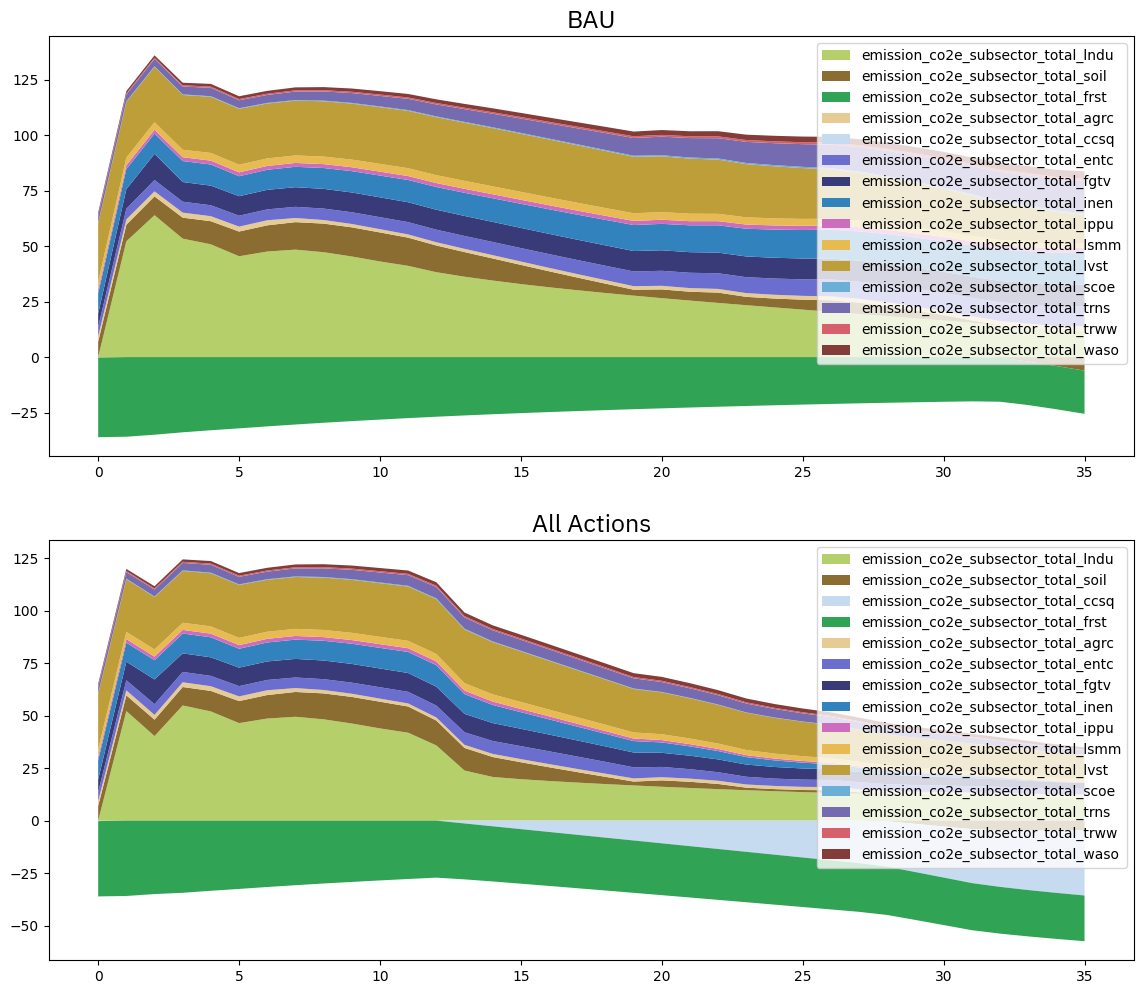

In [162]:
df_base = df_runs[
    df_runs["primary_id"].isin([0])
]

df_aa = df_runs[
    df_runs["primary_id"].isin([68068])
]

fig, ax = plt.subplots(2, 1, figsize = (14, 12))



spp.plot_emissions_stack(
    df_base,
    matt,
    figtuple = (fig, ax[0])
)
ax[0].legend(loc = "upper right")
ax[0].set_title("BAU", fontfamily = "IBM Plex Sans", fontsize = "18")

spp.plot_emissions_stack(
    df_aa,
    matt,
    figtuple = (fig, ax[1])
)
ax[1].legend(loc = "upper right")
ax[1].set_title("All Actions", fontfamily = "IBM Plex Sans", fontsize = "18")
plt.savefig("emission_stacks_20250602.png", dpi = 200)

In [69]:
df_in[[x for x in df_in.columns if "nemomod_entc_renewable_energy_tag" in x]]

,nemomod_entc_renewable_energy_tag_pp_biogas,nemomod_entc_renewable_energy_tag_pp_biomass,nemomod_entc_renewable_energy_tag_pp_coal,nemomod_entc_renewable_energy_tag_pp_coal_ccs,nemomod_entc_renewable_energy_tag_pp_gas,nemomod_entc_renewable_energy_tag_pp_gas_ccs,nemomod_entc_renewable_energy_tag_pp_geothermal,nemomod_entc_renewable_energy_tag_pp_hydropower,nemomod_entc_renewable_energy_tag_pp_nuclear,nemomod_entc_renewable_energy_tag_pp_ocean,nemomod_entc_renewable_energy_tag_pp_oil,nemomod_entc_renewable_energy_tag_pp_solar,nemomod_entc_renewable_energy_tag_pp_waste_incineration,nemomod_entc_renewable_energy_tag_pp_wind,nemomod_entc_renewable_energy_tag_st_batteries,nemomod_entc_renewable_energy_tag_st_compressed_air,nemomod_entc_renewable_energy_tag_st_flywheels,nemomod_entc_renewable_energy_tag_st_pumped_hydro
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


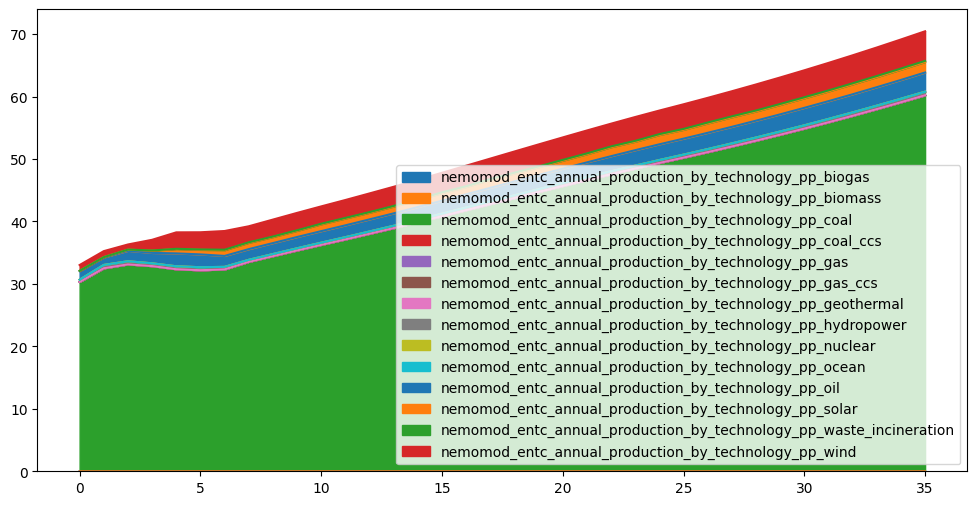

In [171]:
modvar = matt.get_variable("NemoMod Production by Technology")

fig, ax = plt.subplots(figsize = (12, 6))
df_plot = modvar.get_from_dataframe(df_runs[df_runs["primary_id"].isin([0])])
df_plot = df_plot[[x for x in df_plot.columns if "_st_" not in x]].plot.area(ax = ax)

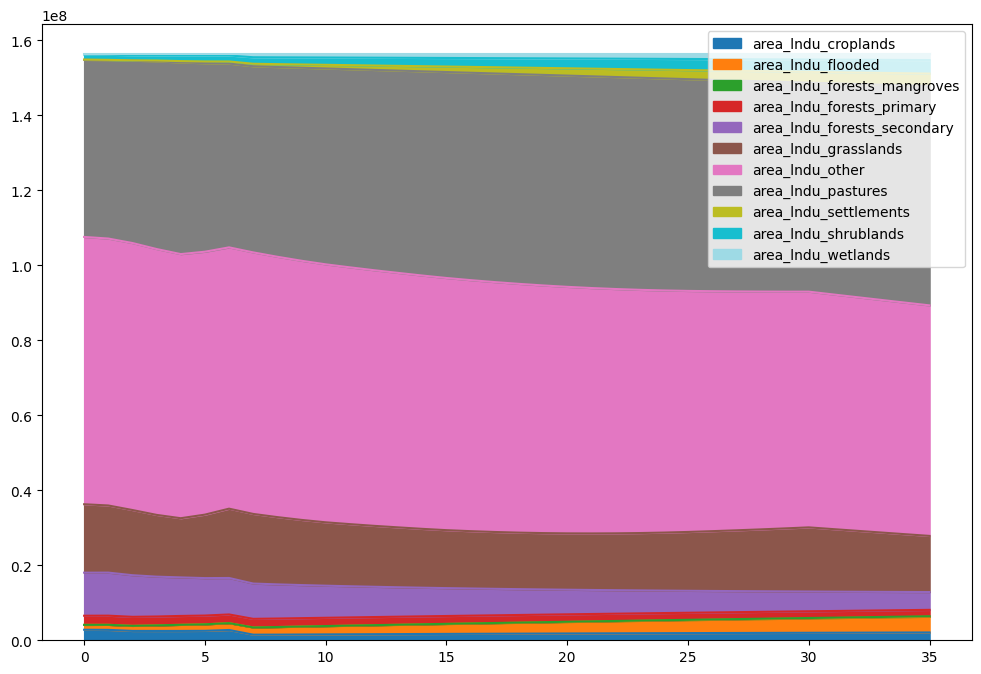

In [302]:
"""[x for x in dir(model_afolu) if "modvar_lndu" in x]
#modvar = model_afolu.modvar_lndu_prob_transition
modvar = model_afolu.modvar_lndu_initial_frac
modvar = matt.get_variable(modvar, )
modvar.get_from_dataframe(df_uganda, )
""";
modvar = matt.get_variable("Land Use Area", )
fig, ax = plt.subplots(figsize = (12, 8))
df_run_no_enerprod[modvar.fields].plot.area(cmap = "tab20", ax = ax, )
ax.legend(loc = "upper right")


In [287]:

importlib.reload(mafl.suo)
importlib.reload(mafl)
df_uganda["lndu_reallocation_factor"] = 0.
model_afolu = mafl.AFOLU(matt, )
df_run_no_enerprod = model_afolu(df_uganda, )#.iloc[0:10], )# include_electricity_in_energy = False, )

# Try running to make sure it works and looks reasonable

In [11]:
models = sm.SISEPUEDEModels(
    matt,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)


In [85]:
df_run = models(df_uganda, include_electricity_in_energy = True, )

2025-06-Jun 12:26:46.217 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmpcloqz76s.sqlite.
2025-06-Jun 12:26:46.321 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmpcloqz76s.sqlite.
2025-06-Jun 12:26:56.975 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-06-Jun 12:27:28.961 Finished modeling scenario.


NameError: name 'df_run_no_enerprod' is not defined

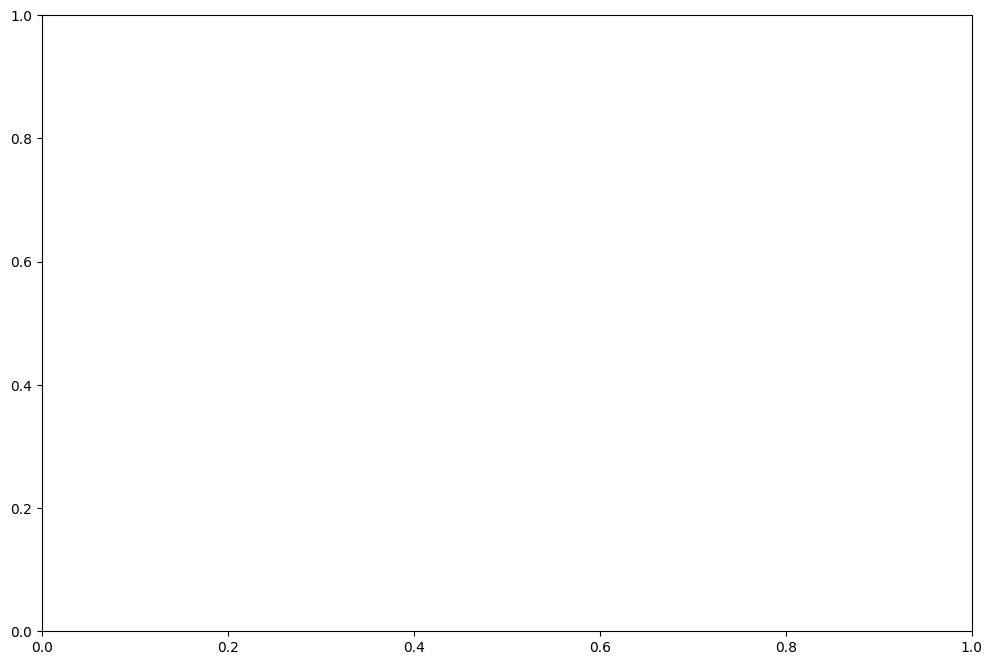

In [5]:
modvar = matt.get_variable("Land Use Area", )
fig, ax = plt.subplots(figsize = (12, 8))
df_run_no_enerprod[modvar.fields].plot.area(cmap = "tab20", ax = ax, )
ax.legend(loc = "upper right")


In [212]:
vals = matt.get_attribute_table("Liquid Waste").key_values
for k in vals:
    print(k)

ww_domestic_rural
ww_domestic_urban
ww_industrial


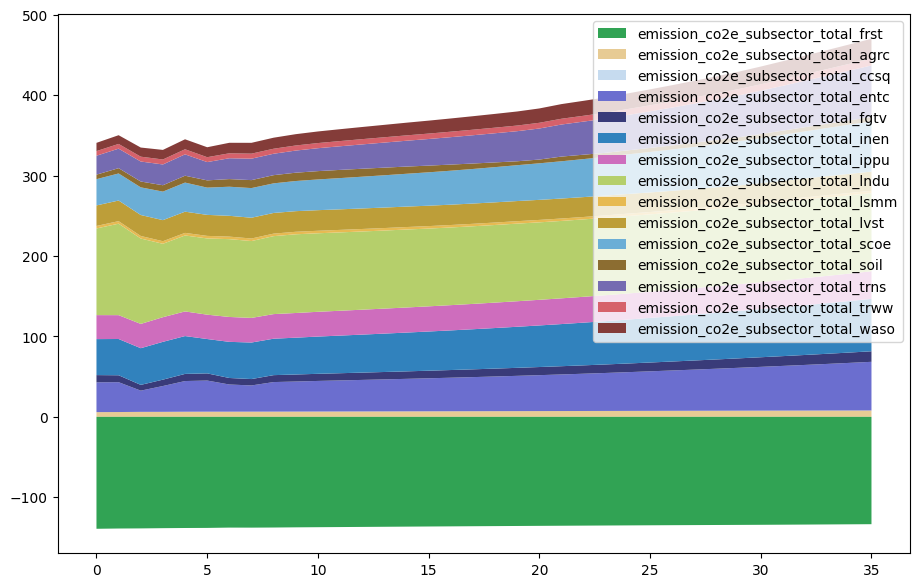

In [102]:
fig, ax = plt.subplots(figsize = (11, 7))
spp.plot_emissions_stack(
    df_run,
    matt,
    figtuple = (fig, ax),
)

ax.legend()


In [153]:
path_data2 = pathlib.Path("/Users/usuario/git/ssp_uganda_data/data_processing/input_data")

In [154]:
df_uganda.to_csv(
    path_data2.joinpath("sisepuede_raw_global_inputs_uganda.csv"),
    encoding = "UTF-8",
    index = None,
)

In [150]:
skip = 0
path_data

PosixPath('/Users/usuario/git/sisepuede_region_nbs/uganda_testing/data')

In [202]:
import sisepuede.transformers.transformers as trf2
importlib.reload(trf2)

transformers = trf2.Transformers(
    {},
    df_input = df_uganda,
)



In [194]:
vec = [0]*12 + [1]*24
vec = np.array(vec)

In [205]:
df_tmp = transformers._trfunc_lndu_bound_class(
    dict_directional_categories_to_magnitude = {
        ("forests_primary", "min"): 500_000,
        ("pastures", "max"): 1_500_000,
    },
    vec_implementation_ramp = np.array(
        [0]*12 + [1]*24
    )
)
modvar_bound_max = matt.get_variable(models.model_afolu.modvar_lndu_constraint_area_max, )
modvar_bound_min = matt.get_variable(models.model_afolu.modvar_lndu_constraint_area_min, )
modvar_bound_max.get_from_dataframe(df_tmp, )


,area_lndu_supremum_croplands_ha,area_lndu_supremum_flooded_ha,area_lndu_supremum_forests_mangroves_ha,area_lndu_supremum_forests_primary_ha,area_lndu_supremum_forests_secondary_ha,area_lndu_supremum_grasslands_ha,area_lndu_supremum_other_ha,area_lndu_supremum_pastures_ha,area_lndu_supremum_settlements_ha,area_lndu_supremum_shrublands_ha,area_lndu_supremum_wetlands_ha
0,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
5,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
6,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
7,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
8,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
9,107136350.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [120]:
modvar_frst_sf = matt.get_variable(models.model_afolu.modvar_frst_sq_co2, )
modvar_lndu_sf = matt.get_variable(models.model_afolu.modvar_lndu_sf_co2, )

In [158]:
df_tmp = transformers.lndu_expand_silvopasture(
    magnitude = 0.2,
)

modvar_lndu_sf.get_from_dataframe(df_tmp).tail()



,ef_lndu_sequestration_grasslands_kt_co2_ha,ef_lndu_sequestration_other_kt_co2_ha,ef_lndu_sequestration_pastures_kt_co2_ha,ef_lndu_sequestration_settlements_kt_co2_ha,ef_lndu_sequestration_shrublands_kt_co2_ha,ef_lndu_sequestration_wetlands_kt_co2_ha
31,0.0,0.0,0.000523,0.0,0.001387,0.0
32,0.0,0.0,0.000550,0.0,0.001387,0.0
33,0.0,0.0,0.000578,0.0,0.001387,0.0
34,0.0,0.0,0.000605,0.0,0.001387,0.0
35,0.0,0.0,0.000633,0.0,0.001387,0.0


In [121]:
modvar_lndu_sf.get_from_dataframe(
    df_uganda,
).tail()



,ef_lndu_sequestration_grasslands_kt_co2_ha,ef_lndu_sequestration_other_kt_co2_ha,ef_lndu_sequestration_pastures_kt_co2_ha,ef_lndu_sequestration_settlements_kt_co2_ha,ef_lndu_sequestration_shrublands_kt_co2_ha,ef_lndu_sequestration_wetlands_kt_co2_ha
31,0.0,0.0,0.0,0.0,0.001387,0.0
32,0.0,0.0,0.0,0.0,0.001387,0.0
33,0.0,0.0,0.0,0.0,0.001387,0.0
34,0.0,0.0,0.0,0.0,0.001387,0.0
35,0.0,0.0,0.0,0.0,0.001387,0.0


In [124]:
modvar_frst_sf.get_from_dataframe(
    df_uganda,
).tail()



,ef_frst_sequestration_mangroves_kt_co2_ha,ef_frst_sequestration_primary_kt_co2_ha,ef_frst_sequestration_secondary_kt_co2_ha
31,0.004603,0.001552,0.003164
32,0.004603,0.001552,0.003164
33,0.004603,0.001552,0.003164
34,0.004603,0.001552,0.003164
35,0.004603,0.001552,0.003164


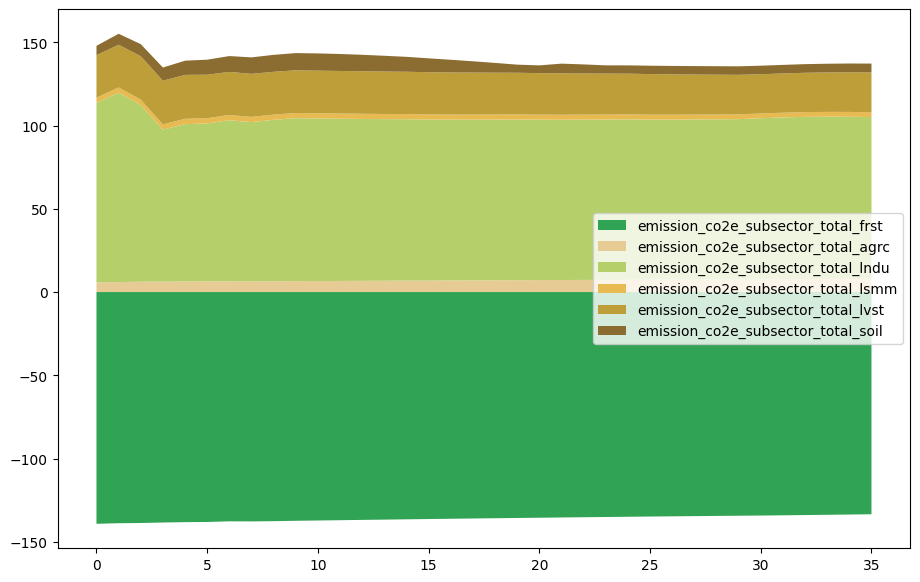

In [159]:
df_out_full = models.model_afolu(df_uganda, )
fig, ax = plt.subplots(figsize = (11, 7))
spp.plot_emissions_stack(
    df_out_full,
    matt,
    figtuple = (fig, ax),
)

ax.legend()




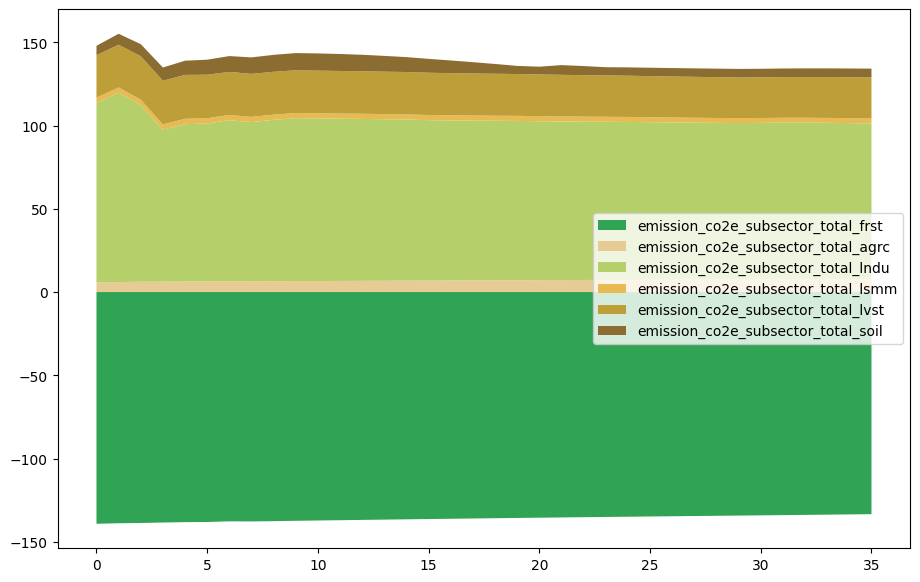

In [160]:
df_out_tmp = models.model_afolu(df_tmp, )
fig, ax = plt.subplots(figsize = (11, 7))
spp.plot_emissions_stack(
    df_out_tmp,
    matt,
    figtuple = (fig, ax),
)

ax.legend()




In [162]:
fields_emission = [
    matt.get_subsector_emission_total_field(x)
    for x in matt.get_sector_subsectors("AFOLU")
]

df_out_tmp[fields_emission].sum(axis = 1).tail()



31    0.305845
32    0.524139
33    0.666147
34    0.741733
35    0.790590
dtype: float64

In [18]:
[x for x in dir(models.model_afolu) if "modvar_lndu" in x]

['modvar_lndu_area_by_cat',
 'modvar_lndu_area_converted',
 'modvar_lndu_area_converted_from_type',
 'modvar_lndu_area_converted_to_type',
 'modvar_lndu_area_improved',
 'modvar_lndu_constraint_area_max',
 'modvar_lndu_constraint_area_min',
 'modvar_lndu_ef_ch4_boc',
 'modvar_lndu_ef_co2_conv',
 'modvar_lndu_emissions_ch4_from_wetlands',
 'modvar_lndu_emissions_co2_sequestration',
 'modvar_lndu_emissions_conv',
 'modvar_lndu_emissions_conv_away',
 'modvar_lndu_factor_soil_carbon',
 'modvar_lndu_factor_soil_inputs_supremum_no_manure',
 'modvar_lndu_factor_soil_management_infinum',
 'modvar_lndu_factor_soil_management_supremum',
 'modvar_lndu_frac_dry',
 'modvar_lndu_frac_fertilized',
 'modvar_lndu_frac_increasing_net_exports_met',
 'modvar_lndu_frac_increasing_net_imports_met',
 'modvar_lndu_frac_mineral_soils',
 'modvar_lndu_frac_pastures_improved',
 'modvar_lndu_frac_temperate',
 'modvar_lndu_frac_tropical',
 'modvar_lndu_frac_wet',
 'modvar_lndu_initial_frac',
 'modvar_lndu_prob_tran

In [13]:
df_tmp = "/Users/usuario/git/ssp_uganda/ssp_modeling/input_data/best_input_df_20250605161834.csv"
df_tmp = pd.read_csv(df_tmp, )

In [21]:
modvar = matt.get_variable(
    models.model_afolu.modvar_lndu_prob_transition
)
modvar.get_from_dataframe(df_tmp,)

In [22]:
[x for x in df_tmp.columns if "pij" in x]

['pij_lndu_other_to_forests_mangroves',
 'pij_lndu_settlements_to_settlements',
 'pij_lndu_forests_primary_to_forests_mangroves',
 'pij_lndu_forests_primary_to_grasslands',
 'pij_lndu_other_to_wetlands',
 'pij_lndu_grasslands_to_settlements',
 'pij_lndu_wetlands_to_forests_secondary',
 'pij_lndu_forests_mangroves_to_grasslands',
 'pij_lndu_grasslands_to_wetlands',
 'pij_lndu_grasslands_to_forests_mangroves',
 'pij_lndu_croplands_to_forests_primary',
 'pij_lndu_other_to_other',
 'pij_lndu_settlements_to_croplands',
 'pij_lndu_forests_mangroves_to_settlements',
 'pij_lndu_forests_mangroves_to_croplands',
 'pij_lndu_settlements_to_grasslands',
 'pij_lndu_croplands_to_grasslands',
 'pij_lndu_forests_secondary_to_forests_mangroves',
 'pij_lndu_settlements_to_other',
 'pij_lndu_other_to_settlements',
 'pij_lndu_forests_secondary_to_settlements',
 'pij_lndu_forests_primary_to_croplands',
 'pij_lndu_forests_primary_to_forests_primary',
 'pij_lndu_wetlands_to_forests_primary',
 'pij_lndu_grassl